# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("Azdias shape: ", azdias.shape)
print("Feat_info shape: ", feat_info.shape)

Azdias shape:  (891221, 85)
Feat_info shape:  (85, 4)


In [4]:
# Print first few rows of azdias
pd.set_option('display.max_columns', 100)
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Print feat_info
pd.set_option('display.max_rows', 100)
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

# First, we need to identify those columns that have missing or unknown values encoded as strings.
missing_or_unknown = feat_info[feat_info['missing_or_unknown'] != '[]']['attribute'].tolist()

# To avoid Python interpreting the strings 'X' and 'XX' in feat_info as a variables, we need to wrap them in quotes.
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.replace("X", "'X'")
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.replace("'X''X'", "'XX'")

# Next, we need to parse the strings to get the values that are missing or unknown.
# We can use the eval() function to evaluate the string as a Python expression.
# iloc[0] is used to get the first element of the resulting list; alternatively we can use .values[0].
missing_or_unknown_dict = {}
for col in missing_or_unknown:
    missing_or_unknown_dict[col] = eval(feat_info[feat_info['attribute'] == col]['missing_or_unknown'].iloc[0])

# Print the dictionary
missing_or_unknown_dict

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ANREDE_KZ': [-1, 0],
 'CJT_GESAMTTYP': [0],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_VORSORGER': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZTYP': [-1],
 'GEBURTSJAHR': [0],
 'HEALTH_TYP': [-1, 0],
 'LP_LEBENSPHASE_FEIN': [0],
 'LP_LEBENSPHASE_GROB': [0],
 'LP_FAMILIE_FEIN': [0],
 'LP_FAMILIE_GROB': [0],
 'LP_STATUS_FEIN': [0],
 'LP_STATUS_GROB': [0],
 'NATIONALITAET_KZ': [-1, 0],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'RETOURTYP_BK_S': [0],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_KZ': [-1],
 'TITEL_KZ': [-1, 0],
 'VERS_TYP': [-1],
 'ZABEOT

In [7]:
# Next, we need to convert the data that are in the missing_or_unknown_dict to NaNs.
# This is done column by column.
for col in azdias.columns:
    if col in missing_or_unknown_dict:
        # Print column name and values to be replaced
        print(col, missing_or_unknown_dict[col])
        # Print count of all values in the column before replacing
        print(azdias[col].value_counts())
        azdias[col] = azdias[col].replace(missing_or_unknown_dict[col], np.nan)
        # Print count of all values in the column after replacing
        print(azdias[col].value_counts())
        print()

AGER_TYP [-1, 0]
AGER_TYP
-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: count, dtype: int64
AGER_TYP
2.0    98472
1.0    79802
3.0    27104
Name: count, dtype: int64

ALTERSKATEGORIE_GROB [-1, 0, 9]
ALTERSKATEGORIE_GROB
3    358533
4    228510
2    158410
1    142887
9      2881
Name: count, dtype: int64
ALTERSKATEGORIE_GROB
3.0    358533
4.0    228510
2.0    158410
1.0    142887
Name: count, dtype: int64

ANREDE_KZ [-1, 0]
ANREDE_KZ
2    465305
1    425916
Name: count, dtype: int64
ANREDE_KZ
2    465305
1    425916
Name: count, dtype: int64

CJT_GESAMTTYP [0]
CJT_GESAMTTYP
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: count, dtype: int64
CJT_GESAMTTYP
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: count, dtype: int64

FINANZ_MINIMALIST [-1]
FINANZ_MINIMALIST
3    256276
5    168863
4    167182
2    159313
1    139587
Name: count, dtype: int64
FINANZ_MINIMALIST
3    256276
5 

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Get the percentage of missing values per column and sort them in descending order.
missing_values = azdias.isnull().sum() / azdias.shape[0] * 100
missing_values.sort_values(ascending=False, inplace=True)

# Print the columns with more than 20% missing values.
print(missing_values[missing_values > 20])

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64


(array([32.,  7., 37.,  3.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  4.98788179,  9.97576359, 14.96364538, 19.95152717,
        24.93940897, 29.92729076, 34.91517256, 39.90305435, 44.89093614,
        49.87881794, 54.86669973, 59.85458152, 64.84246332, 69.83034511,
        74.8182269 , 79.8061087 , 84.79399049, 89.78187229, 94.76975408,
        99.75763587]),
 <BarContainer object of 20 artists>)

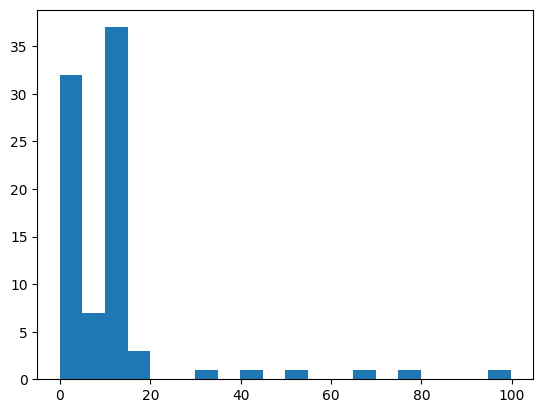

In [9]:
# Use matplotlib's hist() function to visualize the distribution of missing value percentages to find patterns.
plt.hist(missing_values, bins=20)

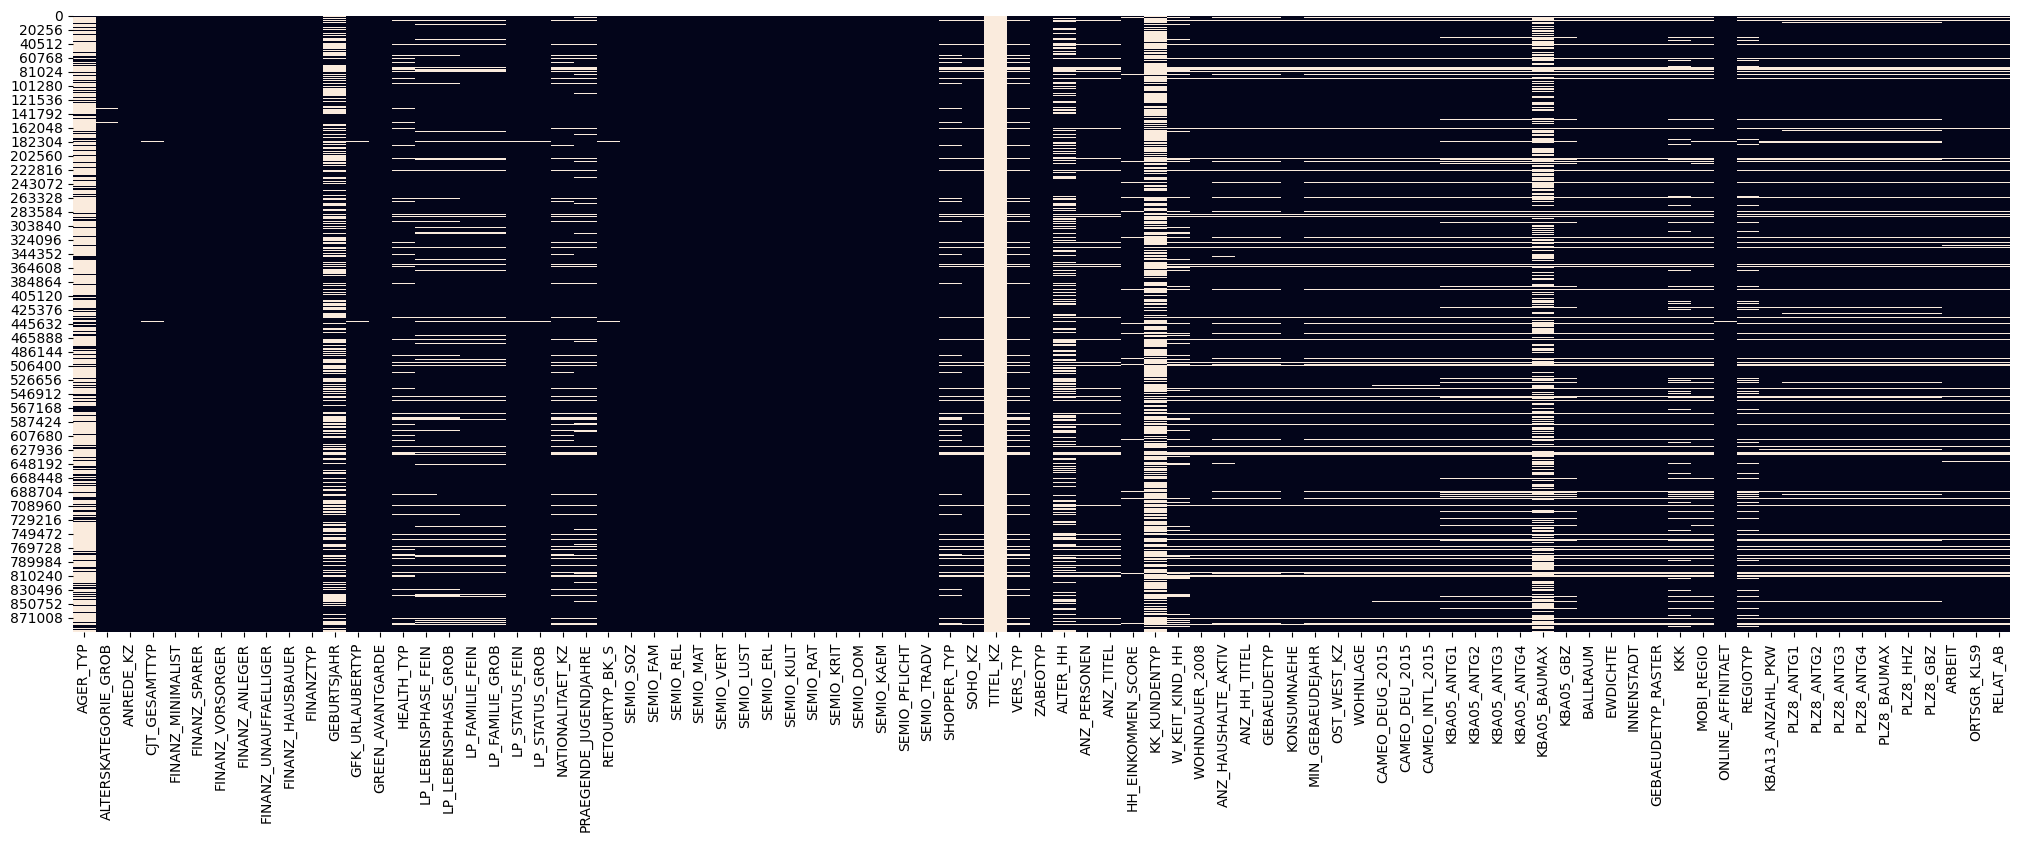

In [10]:
# Investigate patterns in the amount of missing data in each column.
# Plot a heatmap that shows the missing values in all columns.
# White lines indicate missing values.
plt.figure(figsize = (25,8))
sns.heatmap(azdias.isnull(), cbar=False)
plt.show()

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Remove the columns with more than 20% missing values.
azdias = azdias[missing_values[missing_values <= 20].index]

#### Discussion 1.1.2: Assess Missing Data in Each Column

In general, we see in the histogram that most of the columns have less than 20% of missing values. However, there are some columns that have more than 20% of missing values.
The following columns where removed from the dataset (because they have more than 20% of missing values):
- `TITEL_KZ`
- `AGER_TYP`
- `KK_KUNDENTYP`
- `KBA05_BAUMAX`
- `GEBURTSJAHR`
- `ALTER_HH`

Moreover, the heatmap reveals that there are some columns that share missing values. For example, the columns `LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB` share the same missing values. The same happens with the columns `ANZ_PERSONEN` and `ANZ_TITEL`.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?

# Get the percentage of missing values per row and sort them in descending order.
missing_values_row = azdias.isnull().sum(axis=1) / azdias.shape[1] * 100
print(missing_values_row.sort_values(ascending=False))

732775    62.025316
643174    62.025316
472919    60.759494
345274    59.493671
299868    59.493671
            ...    
349047     0.000000
349048     0.000000
349049     0.000000
349050     0.000000
891220     0.000000
Length: 891221, dtype: float64


(array([6.66873e+05, 3.02360e+04, 5.00000e+04, 2.76340e+04, 7.30300e+03,
        5.49800e+03, 7.92500e+03, 1.60800e+03, 6.28000e+02, 2.01000e+02,
        1.14000e+02, 4.10000e+01, 9.00000e+00, 1.40070e+04, 3.99500e+03,
        1.03600e+03, 4.93000e+02, 2.75450e+04, 4.94000e+02, 4.55810e+04]),
 array([ 0.        ,  3.10126582,  6.20253165,  9.30379747, 12.40506329,
        15.50632911, 18.60759494, 21.70886076, 24.81012658, 27.91139241,
        31.01265823, 34.11392405, 37.21518987, 40.3164557 , 43.41772152,
        46.51898734, 49.62025316, 52.72151899, 55.82278481, 58.92405063,
        62.02531646]),
 <BarContainer object of 20 artists>)

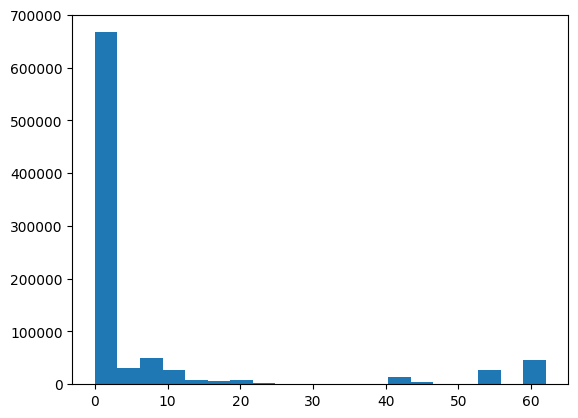

In [13]:
# Print a histogram of the row-wise missing value percentages.
plt.hist(missing_values_row, bins=20)

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Get the indices of the rows with more than 20% missing values.
missing_values_row_index = missing_values_row[missing_values_row > 20].index

# Get the indices of the rows with less than 20% missing values.
not_missing_values_row_index = missing_values_row[missing_values_row <= 20].index

# Divide the data into two subsets based on the number of missing values in each row.
azdias_missing = azdias.iloc[missing_values_row_index]
azdias_not_missing = azdias.iloc[not_missing_values_row_index]

# reindex the two subsets
azdias_missing.reset_index(drop=True, inplace=True)
azdias_not_missing.reset_index(drop=True, inplace=True)

# Print the shape of the two subsets.
print(azdias_missing.shape)
print(azdias_not_missing.shape)

(98934, 79)
(792287, 79)


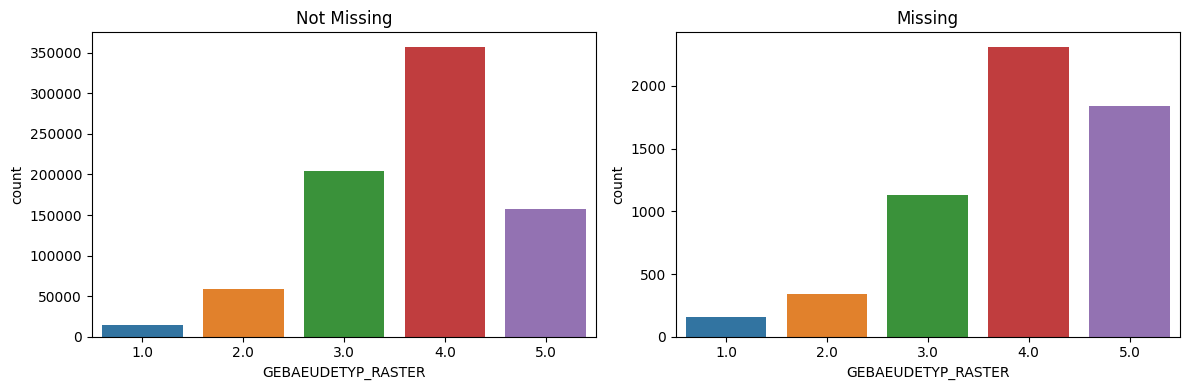

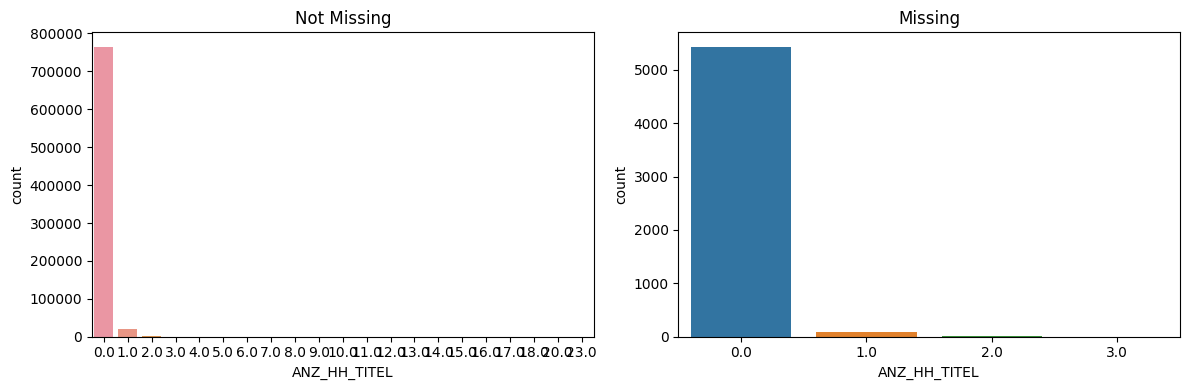

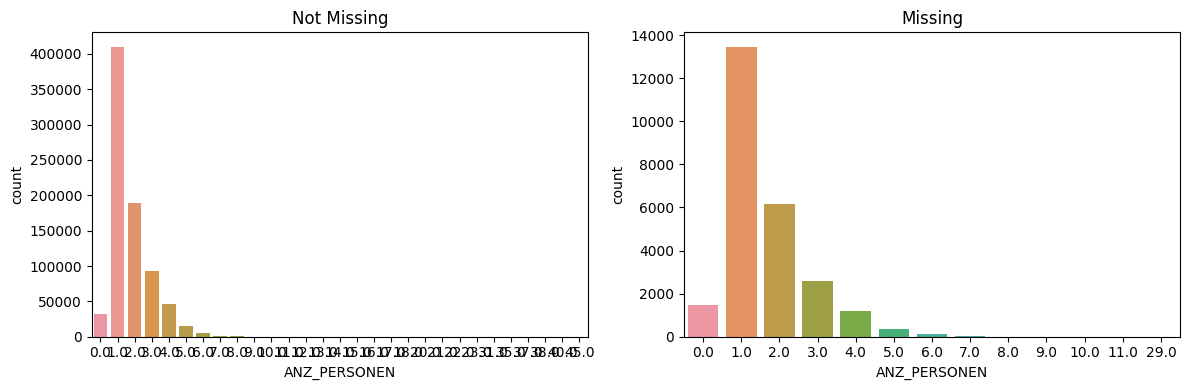

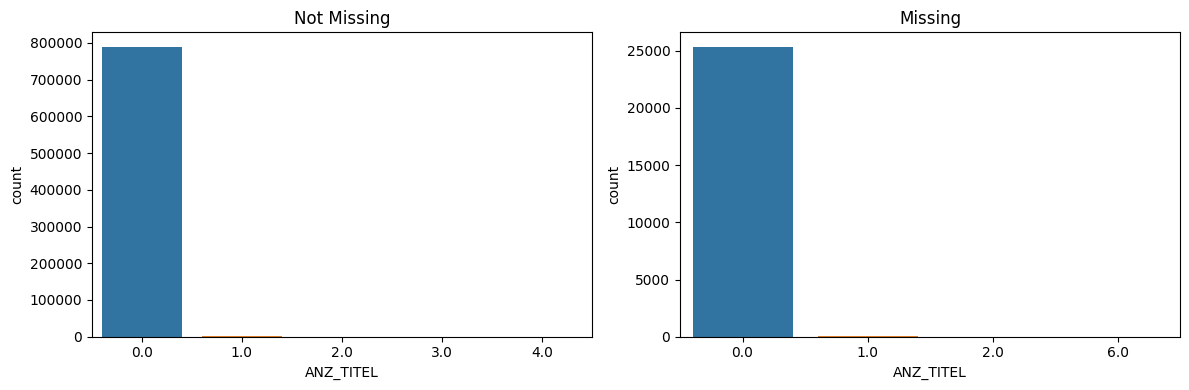

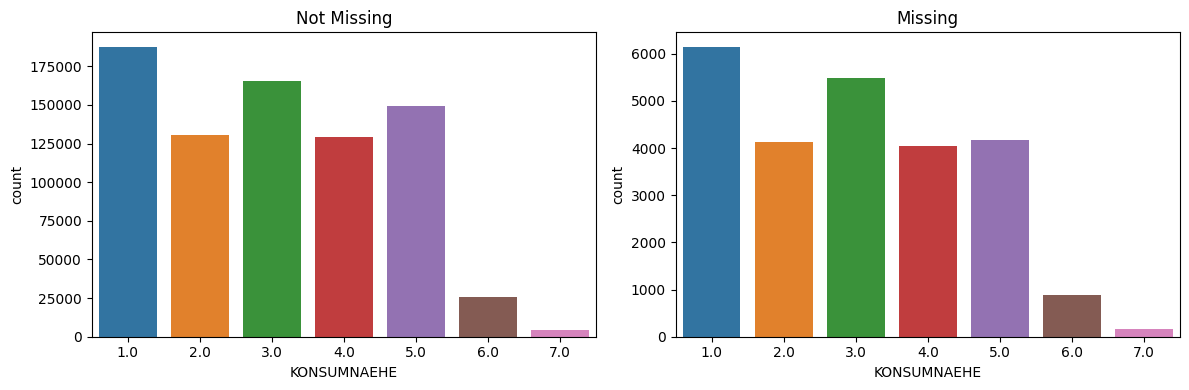

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Define a function to plot the distribution of values for a column in two subsets.
def plot_distribution(column):
    """
    Plot the distribution of values for a column in two subsets.

    INPUT:
    column - a column in the azdias dataframe

    OUTPUT:
    None
    """
    # Create a figure with two subplots.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

    # Plot the distribution of values for the column in the first subplot.
    sns.countplot(data=azdias_not_missing, x=column, ax=ax1)
    ax1.set_title('Not Missing')

    # Plot the distribution of values for the column in the second subplot
    sns.countplot(data=azdias_missing, x=column, ax=ax2)
    ax2.set_title('Missing')

    # Display the plots.
    plt.tight_layout()
    plt.show()

# Plot the distribution of values for five columns in two subsets.
# Use columns with no or few missing values.
plot_distribution('GEBAEUDETYP_RASTER')
plot_distribution('ANZ_HH_TITEL')
plot_distribution('ANZ_PERSONEN')
plot_distribution('ANZ_TITEL')
plot_distribution('KONSUMNAEHE')

In [16]:
# Reassign azdias to be the subset with less than 20% missing values.
azdias = azdias_not_missing

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

From the histogram pairs, we can see that the distribution of the data with many missing values is qualitative not very different from the distribution of the data with few or no missing values. Therefore, we can drop the rows with many missing values. However, we should keep in mind that we only looked at 5 specific columns.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type (i.e., types in feat_info "type" column)?

# Get the number of features of each data type.
# For this we need to check which columns have already been dropped.
feat_info_dropped = feat_info[feat_info['attribute'].isin(azdias.columns)]
# reindex the feat_info dataframe
feat_info_dropped.reset_index(drop=True, inplace=True)
# Get the number of features of each data type.
feat_info_dropped.groupby('type')['attribute'].count()

type
categorical    18
mixed           6
numeric         6
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Get the categorical features that have not been dropped already.
categorical_features = feat_info_dropped[feat_info_dropped['type'] == 'categorical']['attribute'].tolist()

# Get the binary and multi-level categorical features.
binary_features, multi_level_features = [], []
for col in categorical_features:
    if azdias[col].value_counts().shape[0] == 2:
        binary_features.append(col)
    else:
        multi_level_features.append(col)

# Get the binary variable that takes non-numeric values, i.e., where the values are not 0 and 1.
# Use istype() to check the data type of the values in the column.
for col in binary_features:
    if azdias[col].dtype != np.dtype('int64') and azdias[col].dtype != np.dtype('float64'):
        binary_features_to_be_encoded = col

In [19]:
# Print the binary and multi-level categorical features.
print('Binary features:', binary_features)
print('Multi-level features:', multi_level_features)
print('Binary feature to be encoded:', binary_features_to_be_encoded)

Binary features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Binary feature to be encoded: OST_WEST_KZ


In [20]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Re-encode the binary variable to be kept as a feature.
azdias[binary_features_to_be_encoded] = azdias[binary_features_to_be_encoded].replace({'W': 1, 'O': 0})

# Re-encode the multi-level categorical variables to be kept as features.
# Use get_dummies() to perform one-hot encoding.
azdias = pd.get_dummies(azdias, columns=multi_level_features)

# Print the shape of the dataframe after re-encoding.
print(azdias.shape)

(792287, 194)


#### Discussion 1.2.1: Re-Encode Categorical Features

In this step, we re-encoded the following categorical features:
- `OST_WEST_KZ` was re-encoded to `OST_WEST_KZ` with values `0` and `1`.
- `CJT_GESAMTTYP`, `FINANZTYP`, `GFK_URLAUBERTYP`, `LP_FAMILIE_FEIN`, `LP_FAMILIE_GROB`, `LP_STATUS_FEIN`, `LP_STATUS_GROB`, `NATIONALITAET_KZ`, `SHOPPER_TYP`, `ZABEOTYP`, `GEBAEUDETYP`, `CAMEO_DEUG_2015`, `CAMEO_DEU_2015` were re-encoded using one-hot encoding.

Overall, the resulting dataframe after this step has 194 columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [21]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Get the values of the "PRAEGENDE_JUGENDJAHRE" column.
print(azdias['PRAEGENDE_JUGENDJAHRE'].value_counts())

# Define a function to engineer two new variables.
def engineer_two_new_variables_jugendjahre(df):
    """
    Engineer two new variables.

    INPUT:
    df - a dataframe

    OUTPUT:
    df - a dataframe with two new variables
    """
    # Create a new column "DECADE" to encode the decade of the person's youth.
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in [1, 2] else 2 if x in [3, 4] else 3 if x in [5, 6, 7] else 4 if x in [8, 9] else 5 if x in [10, 11, 12, 13] else 6 if x in [14, 15] else np.nan)

    # Create a new column "MOVEMENT" to encode the movement of the person's youth.
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in [1, 3, 5, 8, 10, 12, 14] else 2 if x in [2, 4, 6, 7, 9, 11, 13, 15] else np.nan)

    # Drop the "PRAEGENDE_JUGENDJAHRE" column.
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

    return df

# Engineer two new variables.
azdias = engineer_two_new_variables_jugendjahre(azdias)

# Print the shape of the dataframe after engineering two new variables.
print(azdias.shape)

PRAEGENDE_JUGENDJAHRE
14.0    181525
8.0     140681
10.0     85276
5.0      84400
3.0      53615
15.0     42078
11.0     35448
9.0      33515
6.0      25629
12.0     24340
1.0      20550
4.0      20431
2.0       7470
13.0      5714
7.0       4000
Name: count, dtype: int64
(792287, 195)


In [22]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Get the values of the "CAMEO_INTL_2015" column.
print(azdias['CAMEO_INTL_2015'].value_counts())

# Define a function to engineer two new variables.
def engineer_two_new_variables_cameo(df):
    """
    Engineer two new variables.

    INPUT:
    df - a dataframe

    OUTPUT:
    df - a dataframe with two new variables
    """
    # Create a new column "WEALTH" to encode the wealth of the person's household.
    df['WEALTH'] = pd.Series(np.float64(df['CAMEO_INTL_2015'])).apply(lambda x: 1 if x in [11, 12, 13, 14, 15] else 2 if x in [21, 22, 23, 24, 25] else 3 if x in [31, 32, 33, 34, 35] else 4 if x in [41, 42, 43, 44, 45] else 5 if x in [51, 52, 53, 54, 55] else np.nan)

    # Create a new column
    df['LIFE_STAGE'] = pd.Series(np.float64(df['CAMEO_INTL_2015'])).apply(lambda x: 1 if x in [11, 21, 31, 41, 51] else 2 if x in [12, 22, 32, 42, 52] else 3 if x in [13, 23, 33, 43, 53] else 4 if x in [14, 24, 34, 44, 54] else 5 if x in [15, 25, 35, 45, 55] else np.nan)

    # Drop the "CAMEO_INTL_2015" column.
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    return df

# Engineer two new variables.
azdias = engineer_two_new_variables_cameo(azdias)

# Print the shape of the dataframe after engineering two new variables.
print(azdias.shape)

CAMEO_INTL_2015
51    133492
41     92080
24     90699
14     62565
43     56495
54     45287
25     39413
22     32931
13     26162
45     26038
23     26028
55     23866
52     20508
31     18661
34     18445
15     16913
44     14776
12     13136
35     10316
32     10304
33      9856
Name: count, dtype: int64
(792287, 196)


In [23]:
# Get the number of features of each data type.
# For this we need to check which columns have already been dropped.
feat_info_dropped = feat_info[feat_info['attribute'].isin(azdias.columns)]
# reindex the feat_info dataframe
feat_info_dropped.reset_index(drop=True, inplace=True)
# Get the number of features of each data type.
feat_info_dropped.groupby('type')['attribute'].count()
# Get all mixed-type features.
mixed_features = feat_info_dropped[feat_info_dropped['type'] == 'mixed']['attribute'].tolist()
# Print all mixed-type features.
print(mixed_features)

# Drop all mixed-type features.
azdias.drop(mixed_features, axis=1, inplace=True)
print(azdias.shape)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
(792287, 192)


#### Discussion 1.2.2: Engineer Mixed-Type Features

In this step, we engineered the following mixed-type features:
- `PRAEGENDE_JUGENDJAHRE` was engineered into `DECADE` and `MOVEMENT` features.
- `CAMEO_INTL_2015` was engineered into `WEALTH` and `LIFE_STAGE` features.

The following mixed-type features were dropped:
- `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` were dropped because they are redundant with `CAMEO_INTL_2015`.
- `WOHNLAGE` and `PLZ8_BAUMAX` were dropped because they show some redundancy with `CAMEO_DEUG_2015`.

Overall, the resulting dataframe after this step has 192 columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [68]:
def clean_data(df, df_train, missing_or_unknown_dict):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, dictionary of missing value codes
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs
    for col in df.columns:
        if col in missing_or_unknown_dict:
            df[col] = df[col].replace(missing_or_unknown_dict[col], np.nan)

    # remove selected columns
    columns_to_be_dropped = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df.drop(columns_to_be_dropped, axis=1, inplace=True)

    # remove selected rows
    # Get the percentage of missing values per row and sort them in descending order.
    missing_values_row = df.isnull().sum(axis=1) / df.shape[1] * 100
    # Get the indices of the rows with less than 20% missing values.
    not_missing_values_row_index = missing_values_row[missing_values_row <= 20].index
    # Only select those rows with less than 20% missing values.
    df = df.iloc[not_missing_values_row_index]
    # Reinex the dataframe.
    df.reset_index(drop=True, inplace=True)
    
    # select, re-encode, and engineer column values.
    # Re-encode the binary variable to be kept as a feature.
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({'W': 1, 'O': 0})

    # Re-encode the multi-level categorical variables to be kept as features.
    # Use get_dummies() to perform one-hot encoding.
    df = pd.get_dummies(df, columns=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'])
    # Check if encodigs are missing compared to df_train.
    missing_encodings = list(set(df_train.columns) - set(df.columns))
    # Add the missing encodings to df.
    for col in missing_encodings:
        df[col] = 0

    # Engineer the new variables.
    df = engineer_two_new_variables_jugendjahre(df)
    df = engineer_two_new_variables_cameo(df)
    
    # Drop all mixed-type features.
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)

    # Reorder the columns of the dataframe according to df_train.
    df = df[df_train.columns]
    
    # Return the cleaned dataframe.
    return df

In [81]:
# TEST clean_data()
# load a copy of azdias
azdias_copy = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# clean azdias
azdias_cleaned = clean_data(azdias_copy, azdias, missing_or_unknown_dict)
# print the shape of the cleaned dataframe
print(azdias_cleaned.shape)
# print the shape of the original dataframe
print(azdias.shape)

C:\Users\DEGIMAN\AppData\Local\Temp\ipykernel_17608\128902426.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({'W': 1, 'O': 0})


(792287, 192)
(792287, 192)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [82]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.impute import SimpleImputer

# Impute the missing values with the most frequent value.
imputer = SimpleImputer(strategy='most_frequent')
azdias_cleaned = pd.DataFrame(imputer.fit_transform(azdias_cleaned), columns=azdias_cleaned.columns)

In [83]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

# Initialize a scaler, then apply it to the features.
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns=azdias_cleaned.columns)

### Discussion 2.1: Apply Feature Scaling

In this feature scaling step, I used `Imputer` to replace all missing values with the most frequent of the column. I chose this approach because there are a lot of missing values in the dataset, and I didn't want to lose too much data by removing all rows with missing values. I also didn't want to introduce too much bias by replacing all missing values with the same value, so I chose to replace them with the most frequent of the column. I chose the most frequent value because the mean might result in values that are not in the original dataset. Scaling is done according to the given suggestions.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [86]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

# Initialize PCA.
pca = PCA()
# Fit PCA to the data.
pca.fit(azdias_scaled)

PCA()

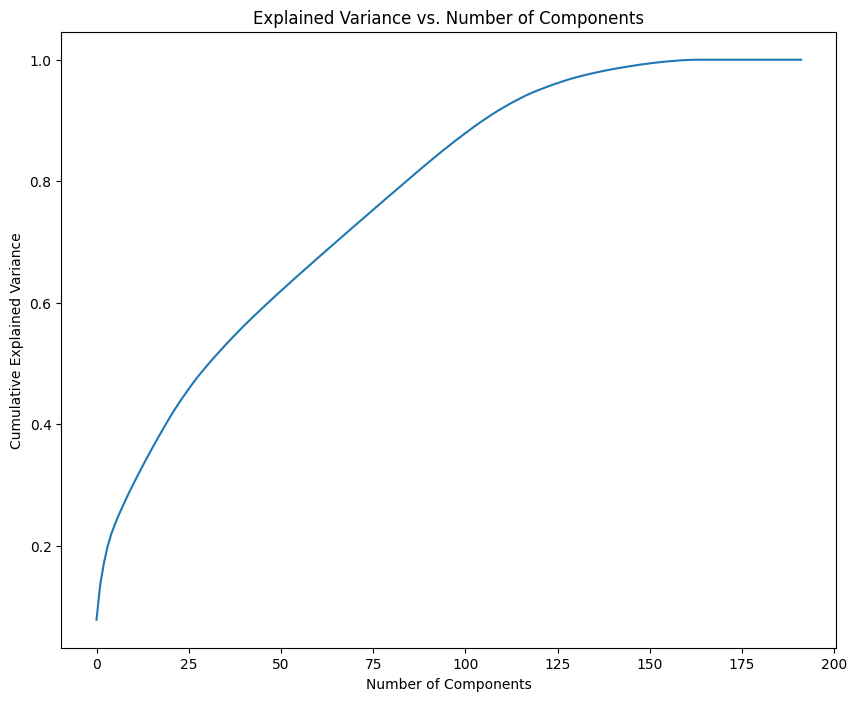

In [29]:
# Investigate the variance accounted for by each principal component.
# Plot the cumulative explained variance ratio as a function of the number of components.
plt.figure(figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [91]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Initialize PCA.
pca = PCA(n_components=106)
# Fit PCA to the data.
pca.fit(azdias_scaled)
# Apply a PCA transformation to the dataset.
azdias_pca = pca.transform(azdias_scaled)

# Check the shape of the dataset after applying PCA.
print(azdias_pca.shape)

(792287, 106)


### Discussion 2.2: Perform Dimensionality Reduction

I chose to keep 106 components because that is the number of components that explain 90% of the variance in the data. I chose to keep 90% of the variance because I wanted to keep as much information as possible while reducing the dimensionality of the data. This corresponds to the drop in variance explained by each component after the 106th component.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [34]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights_to_features(pca, pca_component, df):
    """
    Map weights for the first principal component to corresponding feature names
    and then print the linked values, sorted by weight.
    
    INPUT: PCA object, PCA component, dataframe
    OUTPUT: None
    """
    # Get the weights of the first principal component.
    weights = pca.components_[pca_component]
    # Get the names of the features.
    features = df.columns
    # Create a dataframe with the weights and features.
    df_weights = pd.DataFrame({'weights': weights,
                               'features': features})
    # Sort the dataframe by the weights.
    df_weights.sort_values(by='weights', inplace=True)
    # Print the dataframe.
    print(df_weights)

# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights_to_features(pca, 0, azdias_cleaned)

      weights            features
2   -0.194986   FINANZ_MINIMALIST
47  -0.189532          MOBI_REGIO
51  -0.182490          PLZ8_ANTG1
37  -0.181640         KBA05_ANTG1
41  -0.181181           KBA05_GBZ
..        ...                 ...
54   0.174952          PLZ8_ANTG4
53   0.181355          PLZ8_ANTG3
190  0.185055              WEALTH
29   0.186334  HH_EINKOMMEN_SCORE
110  0.197080  LP_STATUS_GROB_1.0

[192 rows x 2 columns]


In [35]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights_to_features(pca, 1, azdias_cleaned)

      weights               features
188 -0.229241                 DECADE
3   -0.224393          FINANZ_SPARER
6   -0.214510  FINANZ_UNAUFFAELLIGER
13  -0.213786              SEMIO_REL
24  -0.206606            SEMIO_TRADV
..        ...                    ...
16   0.161676             SEMIO_LUST
17   0.179685              SEMIO_ERL
124  0.200226             ZABEOTYP_3
4    0.216984       FINANZ_VORSORGER
0    0.231199   ALTERSKATEGORIE_GROB

[192 rows x 2 columns]


In [36]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights_to_features(pca, 2, azdias_cleaned)

     weights     features
1  -0.344613    ANREDE_KZ
22 -0.314643   SEMIO_KAEM
21 -0.283097    SEMIO_DOM
20 -0.266429   SEMIO_KRIT
17 -0.207828    SEMIO_ERL
..       ...          ...
70  0.135876  FINANZTYP_5
18  0.251109   SEMIO_KULT
11  0.257254    SEMIO_SOZ
12  0.260427    SEMIO_FAM
15  0.318912   SEMIO_VERT

[192 rows x 2 columns]


### Discussion 2.3: Interpret Principal Components

From the first principal component, we can see that some of the most prominent features are `PLZ8_ANTG1`, `PLZ8_ANTG3`, `PLZ8_ANTG4`, `KBA05_ANTG1`, and `KBA05_GBZ`. These features are related to the number of different sized family houses in the PLZ8 and KBA05 regions as well as the number of buildings in the corresponding microcell. `PLZ8_ANTG3` and `PLZ8_ANTG4`, which are the number of 6-10 and 10+ family houses in the PLZ8 region, show both higher weights. This makes sense because the number of 6-10 and 10+ family houses in a region are likely to be similar to each other. In contrast, `PLZ8_ANTG1`, which is the number of 1-2 family houses in the PLZ8 region, shows a significant negative weight. This makes sense because the number of 1-2 family houses in a region is likely to be different from the number of 6-10 and 10+ family houses in the same region. This kind of relationship probably reflects different types of neighborhoods in Germany.

Three other features that show high weights are `WEALTH`, `HH_EINKOMMEN_SCORE` and `FINANZ_MINIMALIST`. These features are related to the financial status of the person. `HH_EINKOMMEN_SCORE` is the person's estimated net household income, and `FINANZ_MINIMALIST` is the person's tendency to be a low spender. These two features show opposite weights, which makes sense because a person with a high net household income is likely to be a high spender. Interestingly, `WEALTH` and `HH_EINKOMMEN_SCORE` show a correlation with `PLZ8_ANTG3` and `PLZ8_ANTG4`. This seems to be counterintuitive because a person with a high net household income might be more likely to live in a 1-2 family house. However, this might be explained by the fact that a person with a high net household income might live in cities where there are more 6-10 and 10+ family houses.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [50]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

scores = []
for i in range(1, 100):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    model = kmeans.fit(azdias_pca)

    # compute the average within-cluster distances.
    # get distances from each sample to each cluster center
    distances = model.transform(azdias_pca)
    # get the distance to the closest cluster
    min_distances = np.min(distances, axis=1)
    # get the average distance to the closest cluster
    avg_within_cluster_distance = np.mean(min_distances)
    scores.append(avg_within_cluster_distance)

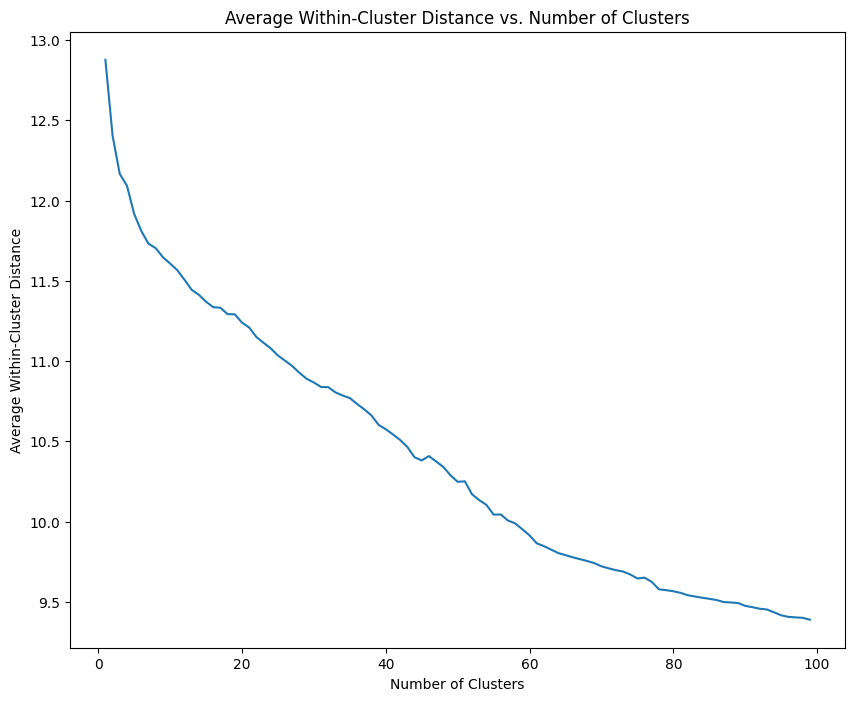

In [51]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10, 8))
plt.plot(range(1, 100), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Within-Cluster Distance')
plt.title('Average Within-Cluster Distance vs. Number of Clusters')
plt.show()

In [58]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=60, random_state=42, n_init='auto')
model = kmeans.fit(azdias_pca)
azdias_preds = model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Following the elbow method, I chose to use 60 clusters. This is because the average distance from each point to its assigned cluster's center decreases significantly from 1 to 60 clusters, but the decrease is not as significant from 60 clusters onwards. However, it is important to note that the average distance from each point to its assigned cluster's center continues to decrease from 60 clusters onwards and the elbow is not very clear.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [92]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [93]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean the customer demographics data.
customers_cleaned = clean_data(customers, azdias_cleaned, missing_or_unknown_dict)
# Impute the missing values with the most frequent value.
customers_cleaned = pd.DataFrame(imputer.transform(customers_cleaned), columns=customers_cleaned.columns)
# Scale the customer demographics data.
customers_scaled = pd.DataFrame(scaler.transform(customers_cleaned), columns=customers_cleaned.columns)
# Apply PCA to the customer demographics data.
customers_pca = pca.transform(customers_scaled)
# Predict the clusters for the customer demographics data.
customers_preds = model.predict(customers_pca)

C:\Users\DEGIMAN\AppData\Local\Temp\ipykernel_17608\128902426.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({'W': 1, 'O': 0})


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

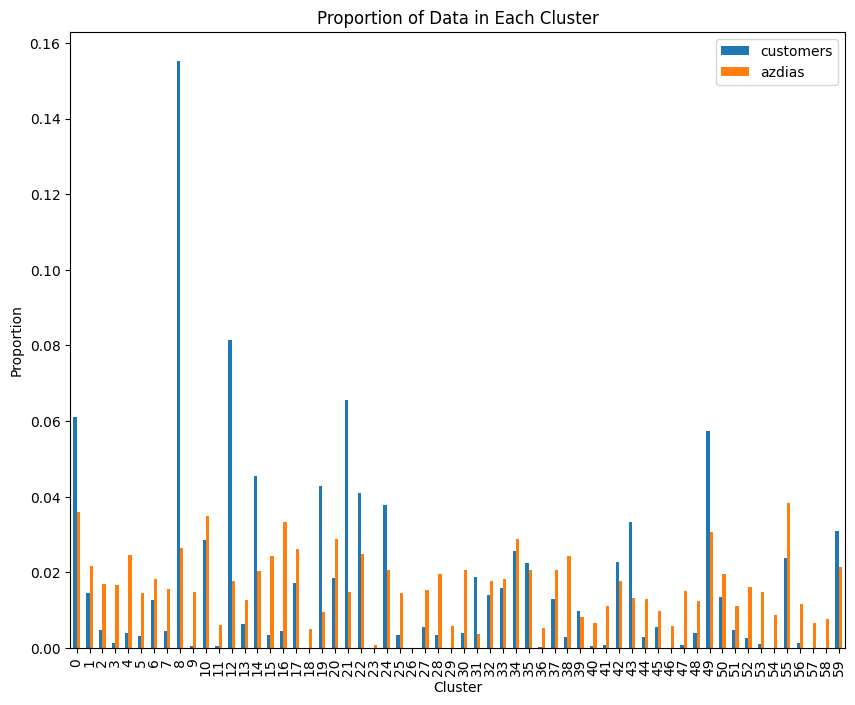

In [94]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Get the proportion of data in each cluster for the customer data.
customers_preds_proportions = pd.Series(customers_preds).value_counts() / len(customers_preds)
# Get the proportion of data in each cluster for the general population.
azdias_preds_proportions = pd.Series(azdias_preds).value_counts() / len(azdias_preds)
# Create a dataframe with the proportions.
df_proportions = pd.DataFrame({'customers': customers_preds_proportions, 'azdias': azdias_preds_proportions})
# Plot the proportions.
df_proportions.plot(kind='bar', figsize=(10, 8))
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Proportion of Data in Each Cluster')
plt.show()

In [107]:
# Map weights for the first three principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights_to_features(pca, 0, azdias_cleaned)
map_weights_to_features(pca, 1, azdias_cleaned)
map_weights_to_features(pca, 2, azdias_cleaned)

      weights            features
42  -0.194986   FINANZ_MINIMALIST
8   -0.189532          MOBI_REGIO
13  -0.182490          PLZ8_ANTG1
3   -0.181640         KBA05_ANTG1
7   -0.181181           KBA05_GBZ
..        ...                 ...
14   0.174952          PLZ8_ANTG4
9    0.181355          PLZ8_ANTG3
190  0.185055              WEALTH
34   0.186334  HH_EINKOMMEN_SCORE
110  0.197080  LP_STATUS_GROB_1.0

[192 rows x 2 columns]
      weights               features
188 -0.229241                 DECADE
41  -0.224393          FINANZ_SPARER
38  -0.214510  FINANZ_UNAUFFAELLIGER
50  -0.213786              SEMIO_REL
59  -0.206605            SEMIO_TRADV
..        ...                    ...
53   0.161676             SEMIO_LUST
54   0.179685              SEMIO_ERL
124  0.200226             ZABEOTYP_3
43   0.216984       FINANZ_VORSORGER
37   0.231199   ALTERSKATEGORIE_GROB

[192 rows x 2 columns]
     weights     features
45 -0.344613    ANREDE_KZ
46 -0.314643   SEMIO_KAEM
58 -0.283097    SEMIO_

In [108]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# The cluster that is overrepresented in the customer data compared to the general population is cluster 8.
cluster_8_center = model.cluster_centers_[8]
# Get the values for the first three principal components.
cluster_8_center_pca = cluster_8_center[:3]
# Print the values.
print("1st PC: ", cluster_8_center_pca[0], "\n2nd PC: ", cluster_8_center_pca[1], "\n3rd PC: ", cluster_8_center_pca[2])

1st PC:  -4.0547939279737 
2nd PC:  0.3775398856209041 
3rd PC:  1.0800999414900507


In [112]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# The cluster that is underrepresented in the customer data compared to the general population is cluster 16.
cluster_16_center = model.cluster_centers_[16]
# Get the values for the first three principal components.
cluster_16_center_pca = cluster_16_center[:3]
# Print the values.
print("1st PC: ", cluster_16_center_pca[0], "\n2nd PC: ", cluster_16_center_pca[1], "\n3rd PC: ", cluster_16_center_pca[2])

1st PC:  4.684431920627238 
2nd PC:  0.3359715871854257 
3rd PC:  0.5177051315750885


### Discussion 3.3: Compare Customer Data to Demographics Data

From the analysis, we can see that the mail-order company's customer base is not universal. The chosen clusters 8 and 16 are over- and underrepresented in the customer data compared to the general population, respectively. Interestingly the corresponding cluster centers show significant differences for the first principal component. In fact, the center of cluster 8 shows a negative value with respect to the first principal component, while the center of cluster 16 shows a positive value. This suggests, that the mail order company might be more popular with customers that live in rural and less densely populated areas and that are more financially conservative. On the other hand, the mail order company might be less popular with customers that live in urban and densely populated areas and that are more financially liberal and that might have other options to buy the products that the mail order company offers.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.